# Visualizing time-resolved LFP-Spiking Analysis of CRCNS PFC2 Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')

In [2]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import neurodsp as ndsp
from scv_funcs import lfpca
from scv_funcs import utils
import pandas as pd
import pandas.plotting as pdplt

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 13}
import matplotlib
matplotlib.rc('font', **font)

In [46]:
def compute_pairwise_corr(spkstats, lfpstats, sub_inds, corr_type='spearman', log_power=False, plot_matrix=False):
    fr,isi_cv = spkstats[sub_inds,0], spkstats[sub_inds,2]
    if log_power:
        pwr = lfpstats[sub_inds,:,0]
    else:
        pwr = np.log10(lfpstats[sub_inds,:,0])
    scv = lfpstats[sub_inds,:,1]
    ks_stat = lfpstats[sub_inds,:,2]
    
    num_freqs = pwr.shape[1]
    rho = np.zeros((5,5,num_freqs))
    for freq in range(num_freqs):
        df = pd.DataFrame(np.array([fr, isi_cv, pwr[:,freq], scv[:,freq], ks_stat[:,freq]]).T, columns=labels)
        corr = df.corr(method='spearman').as_matrix()
        rho[:,:,freq] = corr
        if plot_matrix:
            axes = pdplt.scatter_matrix(df, alpha=0.2, figsize=(7, 7), diagonal='kde');
            for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
                # label with correlation coefficient
                axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    return rho

def plot_corrs(corr_mat,f1,f2,labels,freq=None,YL=(-0.5,0.5)):
    if freq is None:
        plt.plot(corr_mat[f1,f2,:,:].T)
    else:
        plt.plot(corr_mat[f1,f2,freq,:].T)
    num_chan = corr_mat.shape[-1]
    re_div = num_chan/3.*2.-0.5 # region division
    plt.xticks([re_div], ["PFC  |  CA1"])
    plt.ylim(YL)
    plt.plot([re_div,re_div], plt.ylim(), 'k--', alpha=0.5)
    plt.plot(plt.xlim(), [0,0], 'r--', alpha=0.5)
    plt.title(labels[f1]+' : '+labels[f2])

In [4]:
# load LFP data
basefolder ='/Users/rdgao/Documents/data/CRCNS/pfc2/EE.049/EE.049'
lfp_file = basefolder+ '_LFP.mat'
lfp_struct = sp.io.loadmat(lfp_file, squeeze_me=True)
data = lfp_struct['lfp'][:96,:]
t = lfp_struct['t']
fs = lfp_struct['fs'] #1250

In [5]:
# load spike data
spike_file = basefolder + '_Behavior.mat'
spike_struct = sp.io.loadmat(spike_file, squeeze_me=True)
cell_info = spike_struct['spikeph']
spike_ind = spike_struct['spikeind'] 
spike_t = spike_struct['spiket'] # 20kHz

# organize spikes into cells, shanks, and areas
# spkt_c, spkt_sh, spkt_re = organize_spikes(spike_t, spike_ind, cell_info)
# _, cells_per_shank = np.unique(cell_info[:,1], return_counts=True)

In [14]:
nperseg= 1250
noverlap= int(nperseg/2)
N_skip=25
filt_bands = [(4,12), (24,40), (150,200)]
#filt_bands = [(0,4),(6,12),(14,20),(30,40),(50,70),(70,100),(150,200)]

# Load results

In [6]:
data_loaded = np.load('../results/pfc2/EE049_filt.npz')
t_win = data_loaded['t_win']
spkstats_cell = data_loaded['spkstats_cell']
spkstats_shank = data_loaded['spkstats_shank']
spkstats_re = data_loaded['spkstats_re']
lfpstats_rw = data_loaded['lfpstats_rw']
lfpstats_summary = data_loaded['lfpstats_summary']
sigpower_all = data_loaded['sigpower_all']
filt_bands = data_loaded['filt_bands']

In [7]:
# get task and rest indices
rest_inds = []
task_inds = []
for i in range(spike_struct['SessionNP'].shape[0]):
    rest_inds.append(np.where(np.logical_and(t_win >= spike_struct['SessionNP'][i,0],t_win <= spike_struct['SessionNP'][i,1]))[0])
    task_inds.append(np.where(np.logical_and(t_win >= spike_struct['SessionNP'][i,1],t_win <= spike_struct['SessionNP'][i,2]))[0])

rest_inds = np.concatenate(rest_inds)
task_inds = np.concatenate(task_inds)

# Visualizing results

### Computing correlations

In [42]:
corr_labels = ['Per Shank', 'All PFC Cells', 'All CA1 Cells']
labels = ['Cell_FR','Cell_ISICV','LFP_PWR','LFP_SCV', 'LFP_KS']
sub_inds = np.arange(len(t_win))[2:-2:] # all indices
sub_inds = task_inds

shank_corr = []
pfc_corr = []
ca1_corr = []
for sh in range(spkstats_shank.shape[0]):    
    # 2 LFP channels per shank
    for chan in range(2):
        shank_corr.append(compute_pairwise_corr(spkstats_shank[sh], lfpstats_rw[sh*2+chan], sub_inds))
        pfc_corr.append(compute_pairwise_corr(spkstats_re[0], lfpstats_rw[sh*2+chan], sub_inds))
        ca1_corr.append(compute_pairwise_corr(spkstats_re[1], lfpstats_rw[sh*2+chan], sub_inds))

# features, features, freq, shank
shank_corr = np.stack(shank_corr, axis=3)
pfc_corr = np.stack(pfc_corr, axis=3)
ca1_corr = np.stack(ca1_corr, axis=3)
all_corr = [shank_corr,pfc_corr,ca1_corr]

/Users/rdgao/Documents/code/research/spectralCV/scv_funcs/utils.py:388: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r**2 * (df / ((1.0 - r) * (1.0 + r)))


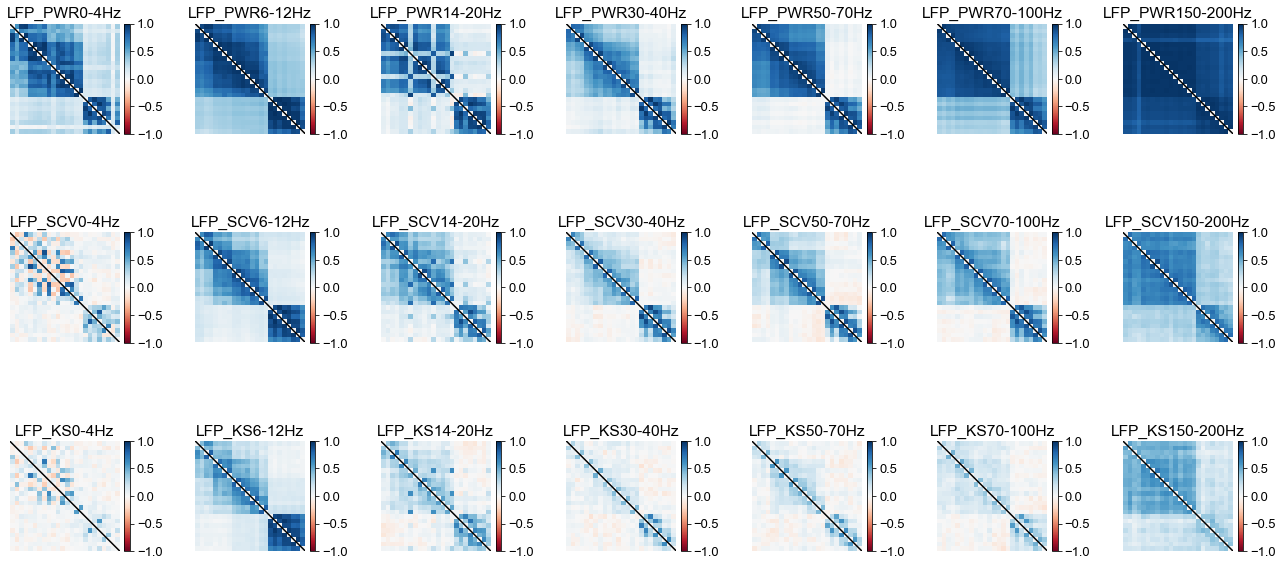

In [43]:
plt.figure(figsize=(18,9))
for freq in range(lfpstats_rw.shape[2]):
    for ind in range(3):
        rho, pv = utils.corrcoefp(lfpstats_rw[:,sub_inds,freq,ind])
        plt.subplot(3,7,ind*7+freq+1)
        utils.corr_plot(rho,bounds=[-1,1])
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[ind+2]+'%i-%iHz'%(filt_bands[freq][0],filt_bands[freq][1]) )
plt.tight_layout()

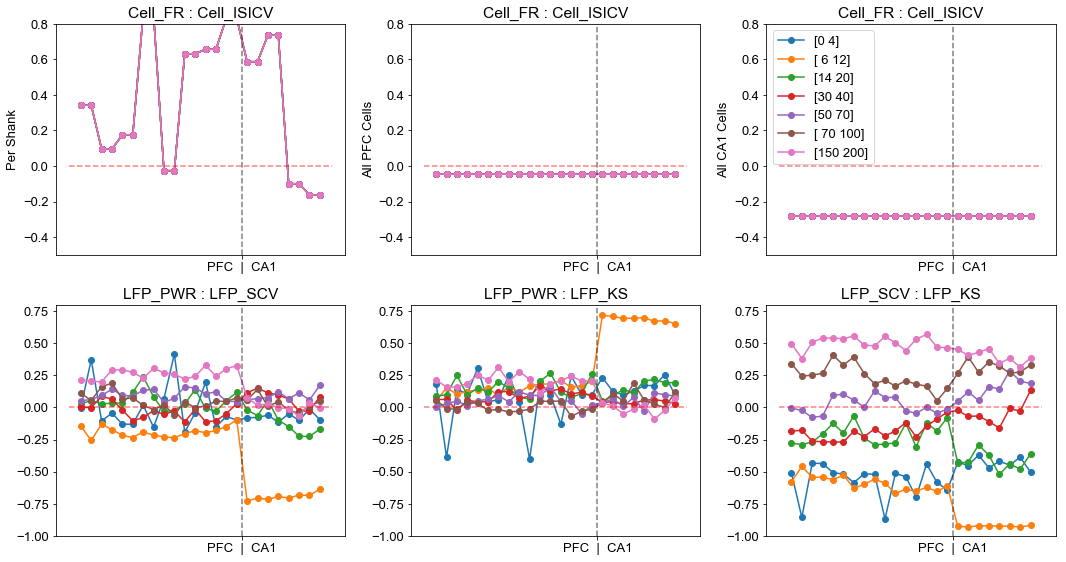

In [44]:
# FR-ISI
plt.figure(figsize=(15,8))
for ind in range(3):
    plt.subplot(2,3,ind+1)
    plot_corrs(all_corr[ind],f1=0,f2=1,labels=labels, YL=(-0.5, 0.8))
    plt.ylabel(corr_labels[ind])

plt.legend(filt_bands)
plt.subplot(2,3,4)
plot_corrs(all_corr[0],f1=2,f2=3,labels=labels, YL=(-1, 0.8))
plt.subplot(2,3,5)
plot_corrs(all_corr[0],f1=2,f2=4,labels=labels, YL=(-1, 0.8))
plt.subplot(2,3,6)
plot_corrs(all_corr[0],f1=3,f2=4,labels=labels, YL=(-1, 0.8))
plt.tight_layout()

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


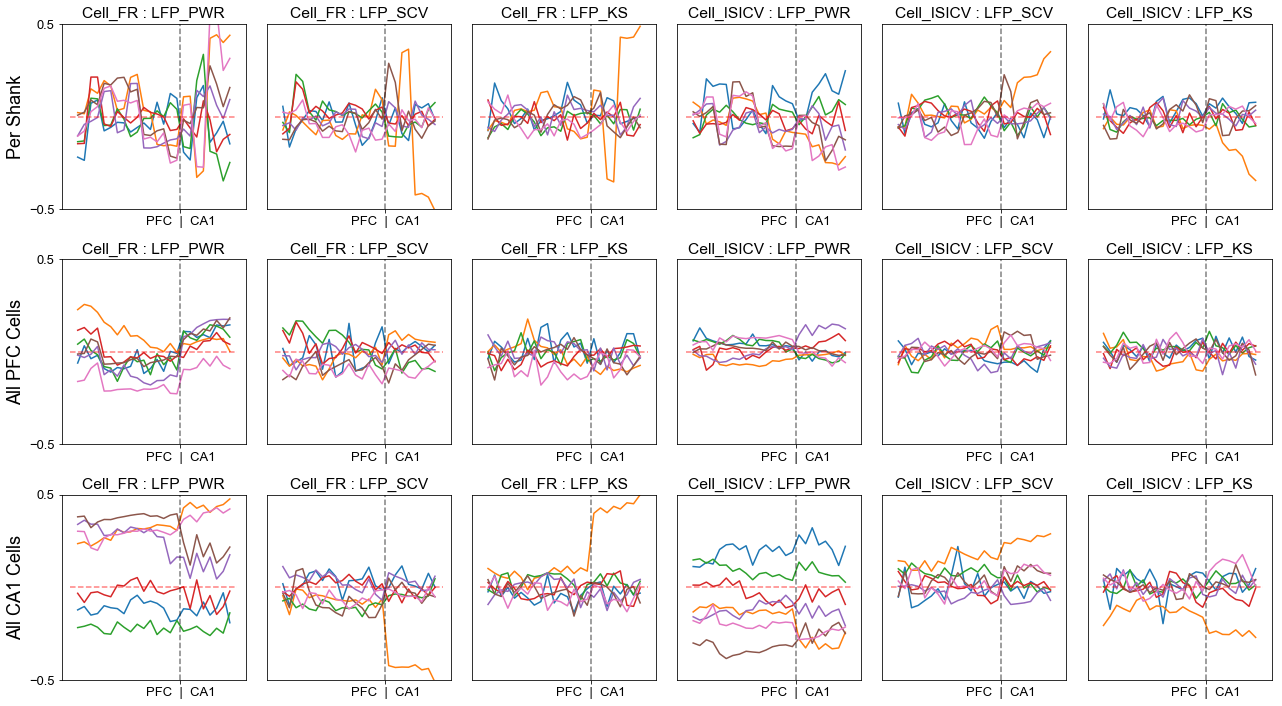

In [47]:
plot_freq = [0,1,2,3,4,5,6]
plt.figure(figsize=(18,10))
for corr_ind in range(3):
    for i,f1 in enumerate([0,1]):
        for j,f2 in enumerate([2,3,4]):
            plt.subplot(3,6,i*3+j+1+corr_ind*6)
            plot_corrs(all_corr[corr_ind],f1,f2,labels, freq=plot_freq)
            plt.yticks([])

    plt.subplot(3,6,1+corr_ind*6)
    plt.ylabel(corr_labels[corr_ind], fontsize=18)
    plt.yticks([-0.5,0.5])
#    plt.legend(filt_bands[plot_freq])
    plt.tight_layout()